This Jupyter Notebook contains a simple SNR Estimator using topics we have already covered in Deep Learning using ANN and CNN's. This has been completed as extension work for my Final Year Project for three main reasons: 

1. Ability to take learned concepts and apply to different real world scenarios. 
2. To display understanding of Neural Networks and Pytorch, which were instrumental for project work.
3. For extra credit

Signal-to-noise ratio (SNR or S/N) is a measure used in science and engineering that compares the level of a desired signal to the level of background noise. SNR is defined as the ratio of signal power to the noise power, often expressed in decibels. A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise.

SNR = (Power(signal))/(Power(noise)) dB

Hence:
if SNR > 1, signal power is greater than noise and vice versa

We will be using a decibel scale for our calculations. For a comprehensive understanding of the dB scale, view below: 

![image info](decibel-scale.jpeg)

In this report, we will introduce an SNR Estimator that uses the spectrogram of a sound wave in order to estimate its SNR. The spectrogram of a signal is a visual representation of the spectrum of frequencies of a signal as it varies with time. We have already seen how CNN is used to process image data and is used for many applications including speech recognition, we will apply it to this problem and observe its performance.







In [1]:
import torch
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import soundfile as sf
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from scipy import signal
from scipy.io import wavfile
import time

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

We will be using the Dataset I and II from previous work which reprsent male and female voices from the TIMIT data-set representing 4 different dialect regions in the United States. Each dataset has 820 audio files. 

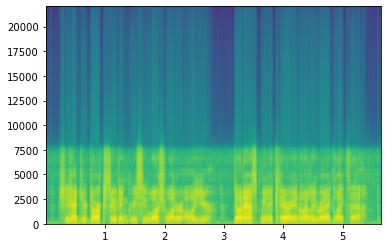

In [2]:
# process and load dataset as a Pytorch tensor for training
transform = transforms.ToTensor()

snr_all = []

# find SNR of each file and save as label 
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))

path_set = "Dataset_Test_M/"

# list of all files on the selected path with global variable .wav
set_investigated = list(Path(path_set).glob('*.wav')) 
list_of_files = np.zeros_like(set_investigated)
full_data = np.zeros_like(set_investigated)
snr_all = np.zeros(len(list_of_files))
# print(len(list_of_files))


for i, file_sig in enumerate(set_investigated):

    # load current signal
    sig, fs_sig = sf.read(str(file_sig))

    # frequencies, times, spectrogram = signal.spectrogram(sig, fs_sig, nperseg=512)

    spectrum, freqs, t, im = plt.specgram(sig,Fs=fs_sig)

    snr = signaltonoise(sig)

    # padding = np.zeros((129, 3000-spectrum.shape[1]))

    # spectrum = np.concatenate((spectrum,padding), axis=1)
    
    full_data[i] = transform(spectrum), snr

    snr_all[i] = snr


In [3]:
# find the range of snr values for dataset
np.amax(snr_all, axis=0)

-50.33527157232448

In [4]:
spectrogram, snr = full_data[0]
print('Shape:', spectrogram.shape, '\nSNR:', snr)

Shape: torch.Size([1, 129, 1945]) 
SNR: -51.16043089176762


In [5]:
full_data[0][0]

tensor([[[7.9046e-08, 2.1122e-08, 2.6965e-08,  ..., 1.3438e-07,
          6.0708e-09, 5.9121e-08],
         [6.8245e-07, 5.3695e-07, 4.7469e-07,  ..., 1.2789e-06,
          1.3062e-06, 9.2997e-07],
         [4.5472e-07, 2.3093e-07, 9.9217e-07,  ..., 2.0830e-06,
          1.2351e-06, 9.6473e-07],
         ...,
         [1.1606e-14, 1.5797e-14, 1.4512e-15,  ..., 1.2536e-16,
          8.0175e-17, 2.2821e-17],
         [1.2092e-14, 7.2200e-15, 6.2940e-15,  ..., 1.4563e-16,
          9.2249e-18, 1.8762e-16],
         [1.0288e-14, 1.7620e-14, 2.0500e-14,  ..., 3.6803e-18,
          1.1478e-17, 1.6478e-16]]], dtype=torch.float64)

In [6]:
# plt.imshow(full_data[0][0].reshape((full_data[0][0].shape[1],full_data[0][0].shape[2])), cmap="gist_yarg");

In [7]:
# split data into test and training set from full_data
train_set = full_data[:int(0.75*len(full_data))]
test_set = full_data[int(0.75*len(full_data)):]

# verify they aren't the same and that lengths are equal 
print(train_set[int(0.75*len(full_data))-1])
print(test_set[0])
print(len(train_set))


(tensor([[[3.8854e-08, 4.8945e-09, 6.0079e-10,  ..., 4.1386e-08,
          5.7794e-08, 6.3349e-08],
         [1.1771e-06, 6.9589e-07, 3.0727e-07,  ..., 9.6127e-07,
          1.3082e-06, 1.1982e-06],
         [1.3151e-06, 4.0482e-07, 3.1055e-07,  ..., 1.7347e-06,
          1.6753e-06, 9.1399e-07],
         ...,
         [5.0233e-14, 2.3500e-14, 8.5616e-15,  ..., 1.3796e-18,
          6.2930e-17, 3.4412e-17],
         [3.5675e-14, 8.7839e-15, 1.0011e-14,  ..., 8.8429e-18,
          1.6872e-16, 5.9993e-17],
         [1.5819e-14, 8.4382e-15, 3.4853e-14,  ..., 7.4936e-18,
          3.3952e-17, 1.0176e-16]]], dtype=torch.float64), -50.69422270802757)
(tensor([[[1.8839e-09, 6.4988e-08, 1.2232e-08,  ..., 5.2959e-09,
          6.8102e-08, 5.5899e-08],
         [1.2383e-06, 1.0569e-06, 3.6733e-07,  ..., 8.8876e-07,
          1.1599e-06, 1.1735e-06],
         [1.5955e-06, 1.5774e-06, 3.3595e-07,  ..., 1.2920e-06,
          8.5528e-07, 1.1943e-06],
         ...,
         [4.4555e-14, 2.4418e-15, 3

In [8]:
# use small batch size, push images to dataloader
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False)

We have now imported our dataset and loaded it into our model, now we will define our neural network and train it using our data. 

In [9]:
for i in range(len(full_data)):
    print(full_data[i][0].shape)

torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
torch.Size([1, 129, 1945])
t

In [10]:
# Define the model with CNN

def get_dimension(W_x, W_y,K,P,S):
    return int(((W_x-K+(2*P))/S) + 1), int(((W_y-K+(2*P))/S) + 1)
    

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # define the conv layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)

        # define the linear layers and flatten image in the next step, must know spectrogram length
        self.fc1 = nn.Linear(16*1945*129, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,1)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) 
        x = F.dropout(x, p=0.6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.dropout(x, p = 0.2)
        x = self.fc3(x)
        return x

In [11]:
torch.manual_seed(50)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4014480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [12]:
# count parameters in our model
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [13]:
count_parameters(model)

    54
     6
   864
    16
481737600
   120
 10080
    84
    84
     1
______
481748909


In [14]:
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# train our model
start_time = time.time()

epochs = 5
train_losses = []

for i in range(epochs):
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.float())  # we don't flatten X-train here
        loss = criterion(y_pred.view(-1,), y_train.float())
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        # if b%5 == 0:
        print(f'epoch: {i:2}  batch: {b:2} loss: {loss.item():10.8f}')
        
        train_losses.append(loss)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch:  1 loss: 2869.85595703
epoch:  0  batch:  2 loss: 1568.82128906
epoch:  0  batch:  3 loss: 415.72149658
epoch:  0  batch:  4 loss: 1033.71777344
epoch:  0  batch:  5 loss: 387.34384155
epoch:  0  batch:  6 loss: 712.05786133
epoch:  0  batch:  7 loss: 6269.40625000
epoch:  0  batch:  8 loss: 713.55212402
epoch:  0  batch:  9 loss: 170.61392212
epoch:  0  batch: 10 loss: 1481.47631836
epoch:  0  batch: 11 loss: 1340.25854492
epoch:  0  batch: 12 loss: 622.63610840
epoch:  0  batch: 13 loss: 437.79571533
epoch:  1  batch:  1 loss: 235.29281616
epoch:  1  batch:  2 loss: 183.64613342
epoch:  1  batch:  3 loss: 111.75362396
epoch:  1  batch:  4 loss: 497.80889893
epoch:  1  batch:  5 loss: 513.12231445
epoch:  1  batch:  6 loss: 948.61944580
epoch:  1  batch:  7 loss: 1882.00268555
epoch:  1  batch:  8 loss: 1134.33276367
epoch:  1  batch:  9 loss: 653.08160400
epoch:  1  batch: 10 loss: 299.25616455
epoch:  1  batch: 11 loss: 1787.42846680
epoch:  1  batch: 12 loss: 1312

In [48]:
# Run the testing batches
test_losses = []

for i in range(epochs):
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b+=1
            # Apply the model
            y_val = model(X_test.float())

            
            loss = criterion(y_val.view(-1,), y_test.float())
            test_losses.append(loss)

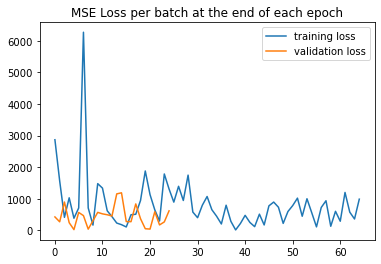

In [60]:
plt.plot(train_losses_plot, label='training loss')
plt.plot(test_losses_plot, label='validation loss')
plt.title('MSE Loss per batch at the end of each epoch')
plt.legend();

In [61]:
torch.save(model.state_dict(), 'SNR_Estimator.pt')

In [86]:
def test_new_data(model,x):
    with torch.no_grad():
        z = model(x.double())
    print(f'\nThe predicted SNR is {z.item():.2f} dB')

In [87]:
# define model 
model_new = ConvolutionalNetwork()
model_new.load_state_dict(torch.load('SNR_Estimator.pt'));

In [88]:
model_new.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4014480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [96]:
# test_new_data(model_new,full_data[0][0].double())